In [10]:
# Loading libraries for the course
import random
import matplotlib.pyplot as plt             # Library used for plotting
from matplotlib.patches import Rectangle    # Module to plot a rectangle in the image
import urllib.request                       # Library to download data
import numpy as np                          # Library for array manipulation
import seaborn as sn                        # Library for advanced plotting
import pandas as pd                         # Library to manipulate data frames
import tifffile                             # Library to store numpy arrays as TIFF
import pathlib                              # Library to work with file paths
from pathlib import Path                    # Library to work with file paths
import skimage                              # Library for image manipulation. scikit-image
from skimage.io import imread               # Module from skimage
from matplotlib import animation            # Module to plot animations
from skimage import filters, measure, segmentation, color
from scipy.ndimage import gaussian_filter
from skimage.filters import difference_of_gaussians
import pandas as pd
from cellpose import models
from scipy import ndimage as ndi

In [11]:
# Loading data

figName = '../Drug7_1000nM/rep1_FOV1.tif'
img = imread(str(figName))


Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


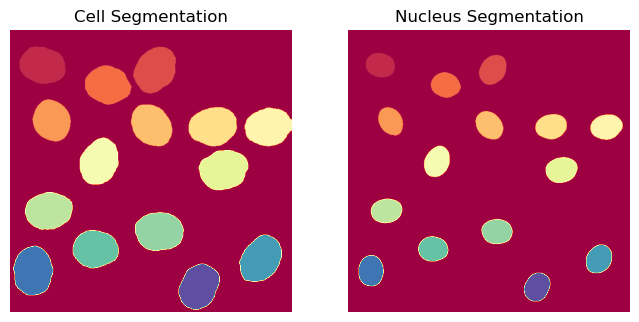

Values in mask:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


In [12]:
from cellpose import models, plot

img_cyto_max = np.max(img[:, :, :, 1], axis = 0)
model1 = models.Cellpose(gpu = False, model_type = 'nuclei')

# Apply the model to your image
masks_cyto, flows, styles, diams = model1.eval(img_cyto_max, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow(masks_cyto,cmap='Spectral')
ax[0].axis('off')
ax[0].set_title('Cell Segmentation')
print('Values in mask: ', np.unique (masks_cyto))

img_nuc = img[0, :, :, 0]
model2 = models.Cellpose(gpu = False, model_type = 'cyto')

# Apply the model to your image
masks_nuc, flows, styles, diams = model2.eval(img_nuc, diameter=None, channels=[0,0])
# Plotting each one of the 3 colors independently
ax[1].imshow(masks_nuc,cmap='Spectral')
ax[1].axis('off')
ax[1].set_title('Nucleus Segmentation')
plt.show()
print('Values in mask: ', np.unique (masks_nuc))

In [13]:
# Make sure that one cell has the same id in both masks
# Get the unique labels in the cell and nucleus masks
cell_labels = np.unique(masks_cyto)
nucleus_labels = np.unique(masks_nuc)

# Initialize the mapping table
mapping_table = {}

# Loop through each cell label
for cell_label in cell_labels:
    # Skip the background
    if cell_label == 0:
        continue

    # Get the mask for the current cell
    current_cell_mask = (masks_cyto == cell_label)

    # Loop through each nucleus label
    for nucleus_label in nucleus_labels:
        # Skip the background
        if nucleus_label == 0:
            continue

        # Get the mask for the current nucleus
        current_nucleus_mask = (masks_nuc == nucleus_label)

        # If the current cell and the current nucleus overlap, add them to the mapping table
        if np.any(current_cell_mask & current_nucleus_mask):
            mapping_table[cell_label] = nucleus_label
            break
updated_masks_nuc = masks_nuc.copy()

# Loop through each item in the mapping table
for cell_label, nucleus_label in mapping_table.items():
    # Update the nucleus label in the nucleus mask
    updated_masks_nuc[masks_nuc == nucleus_label] = cell_label
masks_nuc = updated_masks_nuc

calculate the number of mRNAs in each nuclei and cytoplasm

In [15]:
# mRNA identification
threshold_m = 0.025

t_total = img.shape[0]

df_m_n = pd.DataFrame()
df_m_c = pd.DataFrame()
for t in range(t_total):

    df_m_n['cell id'] = np.nan
    df_m_n['frame'+str(t+1)] = np.nan
    df_m_c['cell id'] = np.nan
    df_m_c['frame'+str(t+1)] = np.nan

for t in range(t_total):
    mRNA = img[t, :, :, 2]
    mRNA_filtered = difference_of_gaussians(mRNA,low_sigma=1, high_sigma=5)

    mRNA_binary = mRNA_filtered.copy()
    mRNA_binary[mRNA_binary>=threshold_m] = threshold_m # Making spots above the threshold equal to the threshold value.
    mRNA_binary[mRNA_binary<threshold_m] = 0 # Making spots below the threshold equal to 0.

    mRNA_binary[mRNA_binary!=0] = 1 # Binarization

    spot_contours = measure.find_contours(mRNA_binary, 0.9)

    labels_m = measure.label(mRNA_binary)

    props = measure.regionprops(labels_m, intensity_image=mRNA)

    # Initialize a list to store the intensities
    areas = []

    # Loop through each mRNA in the image
    for prop in props:
        # Calculate the intensity of the current mRNA and add it to the list

        areas.append(prop.area)

    areas = np.array(areas)
    areas_sorted = np.sort(areas)
    start = np.percentile(areas_sorted, 10)
    end = np.percentile(areas_sorted, 50)
    selected_areas = areas_sorted[(areas_sorted>=start) & (areas_sorted<=end)]
    single_mRNA_area = np.mean(selected_areas)

    cell_id = np.unique(masks_cyto)

    for id in cell_id:
        # Skip the background
        if id == 0:
            continue

        # Get the mask for the current cell
        nuc_mask = (masks_nuc == id)

        # Calculate the properties of the mRNAs in the current cell
        props_n = measure.regionprops(labels_m * nuc_mask, intensity_image = mRNA)

        # Initialize the total area, total intensity and count for the current cell
        total_area_n = 0
        count_n = 0

        # Loop through each mRNA in the current cell
        for prop in props_n:
            # Update the total area, total intensity and count
            total_area_n += prop.area

        count_n = round(total_area_n / single_mRNA_area)
        # Add the results for the current cell to the DataFrame

        df_m_n.loc[id-1, 'cell id'] = int(id)
        df_m_n.loc[id-1, 'frame'+str(t+1)] = count_n
        
        # Get the mask for the current cell
        mask_c = (masks_cyto == id)
        mask_n = (masks_nuc == id)
        cyto_mask = mask_c & ~mask_n

        # Calculate the properties of the mRNAs in the current cell
        props_c = measure.regionprops(labels_m * cyto_mask, intensity_image = mRNA)

        # Initialize the total area, total intensity and count for the current cell
        total_area_c = 0
        count_c = 0

        # Loop through each mRNA in the current cell
        for prop in props_c:
            # Update the total intensity and count
            total_area_c += prop.area

        count_c = round(total_area_c / single_mRNA_area)
        # Add the results for the current cell to the DataFrame

        df_m_c.loc[id-1, 'cell id'] = int(id)
        df_m_c.loc[id-1, 'frame'+str(t+1)] = count_c

# Save the DataFrame to a csv file
df_m_n.to_csv('mRNAs_in_nucleus.csv', index=False)
df_m_c.to_csv('mRNAs_in_cyto.csv', index=False)

number and intensity of transcription site in each cell

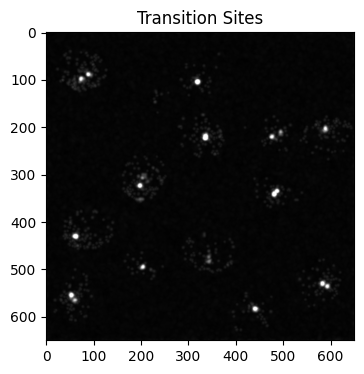

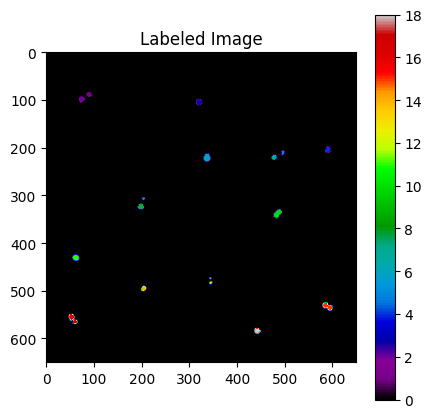

In [ ]:
trans_site = np.max(img[:, :, :, 2], axis=0)

# Display the original image
plt.figure(figsize=(4, 4))
plt.imshow(trans_site, cmap='gray')
plt.title('Transition Sites')
plt.show()

# Apply a threshold to segment the transition sites
threshold = filters.threshold_otsu(trans_site)
binary_trans = trans_site > threshold

# Label connected components
labeled_trans, num_labels = ndi.label(binary_trans)

plt.figure(figsize=(5,5))
plt.imshow(labeled_trans, cmap='nipy_spectral')
plt.colorbar()
plt.title('Labeled Image')
plt.show()

In [ ]:
# Initialize an empty DataFrame
df_trans = pd.DataFrame()

# Initialize an empty list to store the cell each region belongs to
cell_labels = []

# Loop over each frame in the image
for i in range(img.shape[0]):
    # Calculate the properties of each region for the current frame
    regions = measure.regionprops(labeled_trans, intensity_image=img[i,:,:,2])
    
    # Get the mean intensity of each region
    brightness = [region.mean_intensity for region in regions]
    
    # Add the brightness values to the DataFrame
    df_trans['frame'+str(i+1)] = brightness

# Loop over each region
for region in regions:
    # Get the coordinates of the region
    coords = region.coords
    
    # Get the labels of the cells that the region belongs to in masks_cyto
    labels = masks_cyto[coords[:,0], coords[:,1]]
    
    # Get the most common label, which is the cell that the region belongs to
    cell_label = np.argmax(np.bincount(labels))
    
    # Add the cell label to the list
    cell_labels.append(cell_label)

# Add the cell labels to the DataFrame
df_trans.insert(0, 'cell', cell_labels)

df_trans

,cell,frame1,frame2,frame3,frame4,frame5,frame6,frame7,frame8,frame9,...,frame12,frame13,frame14,frame15,frame16,frame17,frame18,frame19,frame20,frame21
0,1,28.946809,187.765957,86.563830,68.648936,146.234043,99.053191,73.531915,37.053191,28.989362,...,31.106383,28.563830,27.829787,31.414894,29.053191,25.042553,29.680851,32.521277,28.702128,114.765957
1,1,83.960784,60.882353,183.019608,97.823529,41.068627,30.352941,31.264706,31.686275,27.558824,...,30.068627,30.813725,29.215686,32.372549,29.931373,28.274510,33.500000,33.274510,29.843137,28.784314
2,2,64.844262,44.704918,35.647541,30.377049,30.163934,51.786885,41.270492,52.860656,51.360656,...,149.426230,72.950820,68.114754,36.016393,132.688525,87.745902,94.622951,219.860656,152.860656,62.942623
3,6,170.100917,126.422018,60.862385,34.403670,26.990826,58.715596,51.550459,34.862385,39.293578,...,30.798165,30.100917,32.990826,84.321101,71.422018,84.100917,79.321101,51.412844,42.266055,30.238532
4,5,57.437500,59.479167,40.312500,29.604167,29.979167,32.833333,145.250000,112.125000,46.000000,...,31.687500,34.479167,29.916667,27.916667,31.270833,27.166667,25.416667,34.125000,30.229167,75.604167
5,4,66.873563,66.074713,32.459770,55.724138,34.678161,173.660920,86.488506,43.810345,36.977011,...,28.172414,36.097701,68.367816,55.195402,75.482759,180.091954,86.459770,54.206897,65.896552,173.931034
6,5,48.176471,38.647059,30.988235,32.564706,31.600000,92.976471,48.211765,158.235294,73.047059,...,28.388235,29.129412,29.235294,29.117647,118.552941,63.352941,187.647059,88.800000,67.811765,43.658824
7,7,31.956522,135.826087,118.260870,76.086957,27.913043,29.260870,29.869565,28.304348,30.086957,...,28.260870,26.260870,30.304348,30.478261,30.173913,28.000000,29.130435,29.913043,29.782609,31.869565
8,7,29.461538,201.490385,102.750000,60.307692,42.923077,27.961538,31.567308,63.682692,52.625000,...,36.701923,35.442308,37.980769,39.769231,89.605769,37.394231,30.432692,30.894231,27.894231,28.490385
9,8,41.724490,33.260204,27.933673,28.698980,32.173469,29.668367,29.362245,63.816327,49.306122,...,34.729592,67.193878,107.147959,48.316327,40.887755,162.612245,155.846939,66.693878,84.683673,149.193878


In [ ]:
# Count the number of transcription sites for each cell
transcription_sites_per_cell = df_trans['cell'].value_counts()

transcription_sites_per_cell

1     2
5     2
7     2
10    2
13    2
2     1
6     1
4     1
8     1
9     1
11    1
12    1
14    1
Name: cell, dtype: int64

In [ ]:
# Save the DataFrame to a csv file
df_trans.to_csv('trans.csv', index=False)